In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
import torchvision
import matplotlib.pyplot as plt
import numpy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\parth\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\parth\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\parth\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

In [10]:
# # Generator
# class Generator(nn.Module):
#     def __init__(self, latent_dim=100):
#         super(Generator, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.Linear(latent_dim, 128 * 7 * 7),
#             nn.ReLU(),
#             nn.Unflatten(1, (128, 7, 7)),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128, momentum=0.78),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64, momentum=0.78),
#             nn.ReLU(),
#             nn.Conv2d(64, 1, kernel_size=3, padding=1),
#             nn.Tanh()  # Output range [-1, 1]
#         )

#     def forward(self, z):
#         img = self.model(z)
#         return img


# # Discriminator
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.25),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ZeroPad2d((0, 1, 0, 1)),
#             nn.BatchNorm2d(64, momentum=0.82),
#             nn.LeakyReLU(0.25),
#             nn.Dropout(0.25),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(128, momentum=0.82),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.25),
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256, momentum=0.8),
#             nn.LeakyReLU(0.25),
#             nn.Dropout(0.25),
#             nn.Flatten(),
#             nn.Linear(256 * 4 * 4, 1),  # Adjusted for feature map size
#             nn.Sigmoid()
#         )

#     def forward(self, img):
#         validity = self.model(img)
#         return validity


In [3]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7), 
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1), 
            nn.Tanh() 
        )

    def forward(self, z):
        img = self.model(z)
        return img


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1), 
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [4]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [5]:

latent_dim = 100
learning_rate = 0.0002
num_epochs = 10

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [23]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        optimizer_G.zero_grad()

        # predict
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        generated_imgs = generator(z)

        # loss gen
        g_loss = adversarial_loss(discriminator(generated_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        # loss disc
        real_loss = adversarial_loss(discriminator(imgs.to(device)), real_labels)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # backwarse
        d_loss.backward()
        optimizer_D.step()

        if i % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, Loss G: {g_loss:.4f}")


Epoch [1/10] Batch 0/938                   Loss D: 0.7403, Loss G: 0.9550
Epoch [1/10] Batch 200/938                   Loss D: 0.2647, Loss G: 1.3277
Epoch [1/10] Batch 400/938                   Loss D: 0.1894, Loss G: 1.6284
Epoch [1/10] Batch 600/938                   Loss D: 0.1473, Loss G: 2.7593
Epoch [1/10] Batch 800/938                   Loss D: 0.1305, Loss G: 4.0315
Epoch [2/10] Batch 0/938                   Loss D: 0.3091, Loss G: 1.0663
Epoch [2/10] Batch 200/938                   Loss D: 0.0843, Loss G: 2.3795
Epoch [2/10] Batch 400/938                   Loss D: 0.1115, Loss G: 2.2934
Epoch [2/10] Batch 600/938                   Loss D: 0.1574, Loss G: 2.0236
Epoch [2/10] Batch 800/938                   Loss D: 0.0736, Loss G: 3.1480
Epoch [3/10] Batch 0/938                   Loss D: 0.0633, Loss G: 3.8245
Epoch [3/10] Batch 200/938                   Loss D: 0.0699, Loss G: 3.5836
Epoch [3/10] Batch 400/938                   Loss D: 0.0647, Loss G: 2.7958
Epoch [3/10] Batch

RuntimeError: Numpy is not available

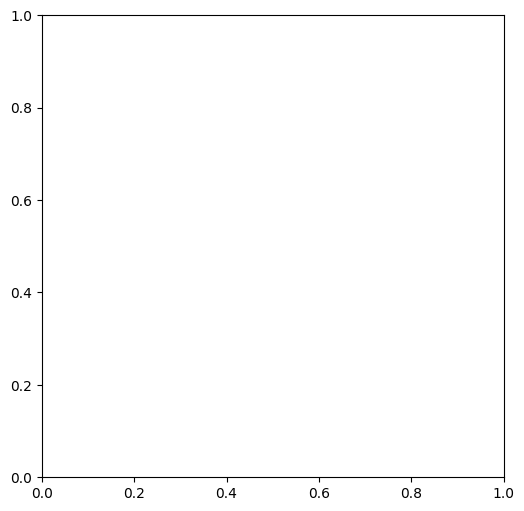

In [11]:
# create images
noise = torch.randn(16, latent_dim).to(device)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
grid = make_grid(generated_images, nrow=4, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()

In [25]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


In [8]:
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

C:\Users\parth\AppData\Local\Temp\ipykernel_13952\1611587311.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
C:\Us

<All keys matched successfully>